# Daily Retreat: Using Sentiment Analysis to<br>Find, Personalize, and Share Positive News from Popular Online Sources
__Aaron Carr, Azucena Faus, and Dave Friesen - ADS-599-01-SU23__

In [1]:
__author__ = 'Aaron Carr, Azucena Faus, Dave Friesen'
__email__ = 'acarr@sandiego.edu, afaus@sandiego.edu, dfriesen@sandiego.edu'
__version__ = '1.0'
__date__ = 'July/August 2023'

## Setup

In [2]:
# Import basic and data access libraries
import numpy as np
import pandas as pd

# Import vector database (senmantic search) libraries
import pinecone
from pinecone import ApiException

# Import model-related libraries
from sklearn.model_selection import train_test_split

# Import visualization libraries
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Import utility libraries
import os

/Users/davidfriesen/opt/anaconda3/lib/python3.9/site-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Set basic np, pd, and plt output defaults (keeping this code 'clean')
%run -i 'defaults.py'

## Data Load and Validation

In [4]:
# Instantiate and confirm master dataframe
news_00_df = pd.read_csv('../data_large/data_preprocessed_w_sw_2023-07-20_13-02-01408354.csv')

# Load pre-processed sentiment
news_04_df = pd.read_csv('../data_large/news-04.csv')
news_04_df = pd.merge(news_00_df, news_04_df, on='text_id')

# Load pre-processed embeddings as numpy array
embeddings = np.load('../data_large/embeddings.npy', allow_pickle=True)
news_04_df['embeddings'] = list(embeddings)

print(news_04_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36405 entries, 0 to 36404
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   text_id                   36405 non-null  int64  
 1   source_name               36405 non-null  object 
 2   author                    36196 non-null  object 
 3   title                     36405 non-null  object 
 4   url                       36405 non-null  object 
 5   publish_date              36405 non-null  object 
 6   article_text              36405 non-null  object 
 7   content                   36405 non-null  object 
 8   processed_text            36403 non-null  object 
 9   processed_text_split      36405 non-null  object 
 10  num_tokens                36405 non-null  int64  
 11  sentiment_vader           36405 non-null  object 
 12  sentiment_vader_compound  36405 non-null  float64
 13  sentiment_vader_cat       36405 non-null  object 
 14  sentim

## Sentiment Analysis: EDA

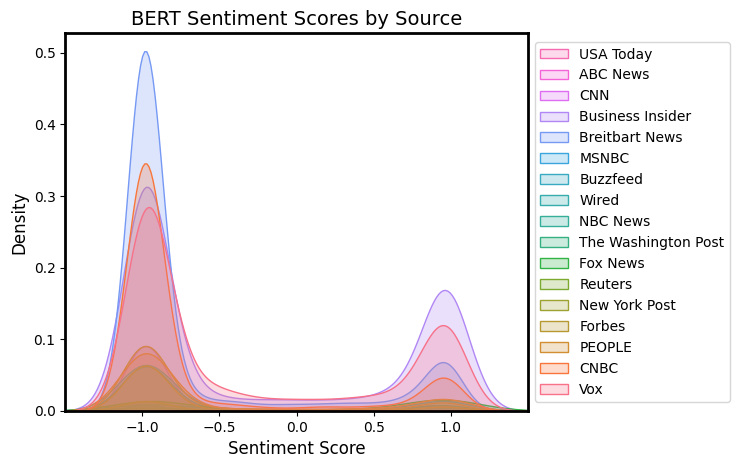

In [5]:
# Plot KDE of BERT
plt.figure(figsize=(7.5, 8.5 / (16 / 9)))
sns.kdeplot(data=news_04_df, x='sentiment_bert', hue='source_name', fill=True)

min_sentiment = news_04_df['sentiment_bert'].min()
max_sentiment = news_04_df['sentiment_bert'].max()
plt.xlim(min_sentiment - 0.5, max_sentiment + 0.5)

plt.title('BERT Sentiment Scores by Source')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')

plt.legend(labels=news_04_df['source_name'].unique(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

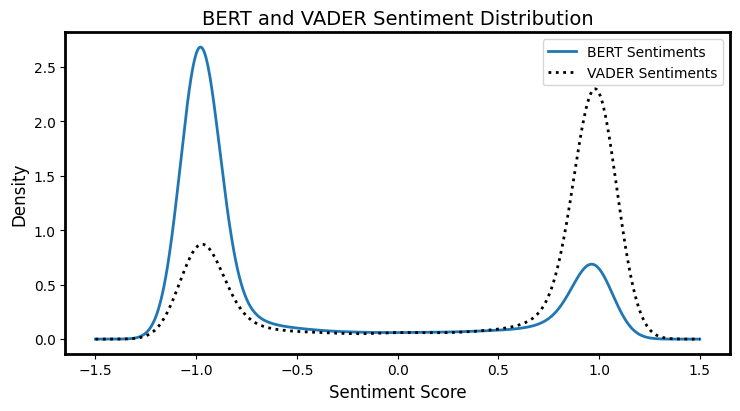

In [6]:
from scipy.stats import gaussian_kde

# Plot distribution comparison

# Compute KDE for 'sentiment_bert'
bert_kde = gaussian_kde(news_04_df['sentiment_bert'])
x_bert = np.linspace(min_sentiment - 0.5, max_sentiment + 0.5, 1000)
y_bert = bert_kde(x_bert)
plt.plot(x_bert, y_bert, label='BERT Sentiments')

# Compute KDE for 'sentiment_vader_compound'
vadar_kde = gaussian_kde(news_04_df['sentiment_vader_compound'])
x_vadar = np.linspace(min_sentiment - 0.5, max_sentiment + 0.5, 1000)
y_vadar = vadar_kde(x_vadar) * len(news_04_df['sentiment_bert']) / len(news_04_df['sentiment_vader_compound'])
plt.plot(x_vadar, y_vadar, linestyle='dotted', color='black', label='VADER Sentiments')

plt.title('BERT and VADER Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')

plt.legend()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [7]:
pd.set_option('display.max_rows', 100)
news_04_df[:100][['title', 'sentiment_vader_compound', 'sentiment_bert']]

,title,sentiment_vader_compound,sentiment_bert
0,"Tito's launches 'Tito's in a Big Can,' an empty cocktail keg listed at $200",0.87,-0.98
1,Search for missing actor Julian Sands continues in 'limited capacity',0.98,0.96
2,Four star running back picks Michigan State over UNC,0.99,-0.97
3,Alabama center Charles Bediako signs one-year deal with San Antonio Spurs,0.98,0.99
4,Ralph Sampson breaks down iconic Boston Celtics-Houston Rockets fight in 1986 playoffs,0.67,0.82
5,Cowherd: Lakers are delusional for wanting to pay Austin Reaves big bucks,0.99,-0.09
6,Recruiting Roundup: Latest Alabama Football recruiting news,1.00,-0.97
7,Eagles’ 2023 training camp preview: Jalen Hurts joins an elite tier of NFL quarterbacks,0.59,-0.38
8,Lincoln Riley’s late-night emoji tweets equal four USC commits on Tuesday,0.92,-0.99
9,Washington passes California as most expensive state for gas: AAA,0.23,-1.00


## Semantic Similarity (experimentation)

In [8]:
V_INDEX = 'news'

# Establish connection to Pinecone
pinecone.init(api_key=os.environ['PINECONE_API_KEY'], environment='us-west1-gcp-free')

# Confirm index
pinecone.list_indexes()

['news']

In [9]:
# Set index and refresh
index = pinecone.Index(V_INDEX)
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.2,
 'namespaces': {'': {'vector_count': 36405}},
 'total_vector_count': 36405}

In [10]:
# Query function
def query_vector(index, df, idx, top_k):
    vector = news_04_df.loc[idx, 'embeddings'].tolist()  # convert numpy array to list
    results = index.query(vector=vector, top_k=top_k, include_values=True)
    return results

# Usage example
results = query_vector(index, news_04_df, 11, 3)

# Extract ids from results and convert to integers
ids = [int(match['id']) for match in results['matches']]

# Get corresponding records from 'news_00_df'
records = news_04_df.loc[ids]

# Display 'article_title' for each record
for id, row in records.iterrows():
    print(f'ID: {id}, Title: {row["title"]}')

ID: 11, Title: Look: Stetson Bennett caught a massive fish in Montauk
ID: 34886, Title: North Carolina anglers go swordfishing, instead catch rare species: 'Prehistoric, almost'
ID: 12473, Title: "Prehistoric, almost': Friends set out swordfishing, catch rare, record-setting pomfret


## Data Partitioning

In [11]:
# Set splits
train_ratio = 0.7; val_ratio = 0.20; test_ratio = 0.10

# Split and profile
train_df, test_df = train_test_split(news_04_df, test_size=1-train_ratio,
                                     random_state=42)
val_df, test_df = train_test_split(test_df, test_size=test_ratio/(test_ratio+val_ratio),
                                   random_state=42)